## Receiving comments from Rediit via API

In [56]:
pip install asyncpraw

In [65]:
import asyncpraw
import pandas as pd
import numpy as np
from google.colab import userdata
import asyncio

# Documentation for asyncpraw https://asyncpraw.readthedocs.io/en/stable/getting_started/quick_start.html
# Get API id and secret at https://old.reddit.com/prefs/apps/

user_agent = f'Reddit_Scrapper 1.0 by /u//{userdata.get("REDDIT_USER")}'
reddit = asyncpraw.Reddit(
    client_id=userdata.get('REDDIT_ID'),
    client_secret=userdata.get('REDDIT_SECRET'),
    user_agent="my user agent",
)

In [58]:
print(reddit.read_only)

True


In [113]:
subreddits = ['OpenAI', 'ChatGPT' 'StableDiffusion', 'midjourney', 'CharacterAI']
data = {'id': [], 'text':[], 'score':[], 'created': []}
for sub in subreddits:
  subreddit = await reddit.subreddit(sub)
  async for submission in subreddit.new(limit=None):
      await submission.load()
      all_comments = await submission.comments()
      for comment in all_comments:
        try:
          id = comment.id
          body = comment.body
          score = comment.score
          created = comment.created_utc
        except:
          pass
        else:
          data['id'] += [id]
          data['text'] += [body]
          data['score'] += [score]
          data['created'] += [created]
  await asyncio.sleep(10)

print(f'{len(data["id"])} comments was retrieved')

29531 comments was retrieved


## Data exploration

In [114]:
df = pd.DataFrame(data)
df.to_csv('reddit_comments.csv', index=False)
df

,id,text,score,created
0,lbf0lpf,how about explain wth paper clip maximizing is,2,1.719998e+09
1,lbf12zy,This,0,1.719998e+09
2,lbezof8,English is not my first language. I often come...,1,1.719997e+09
3,lbejbb4,Here's an older system prompt they used:\n\n ...,11,1.719986e+09
4,lbeilnx,probably different system prompt,4,1.719986e+09
...,...,...,...,...
29526,lb3g5fi,"Eh, I've surpassed 40 without knowing that I s...",9,1.719819e+09
29527,lb3thn1,Naaaah tripping 😯,2,1.719828e+09
29528,lb6ch6d,"I wish the app had them numbered, it'd be so m...",2,1.719863e+09
29529,lb4tc05,I think you gave him the cold shoulder.,2,1.719845e+09


In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29531 entries, 0 to 29530
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       29531 non-null  object 
 1   text     29531 non-null  object 
 2   score    29531 non-null  int64  
 3   created  29531 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 923.0+ KB


## Preprocessing and cleaning data

In [116]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
import re
# download nltk corpus (first time only)
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    |   Package bcp47 is already up-to-dat

True

In [117]:
from tkinter.constants import N
def text_cleaning(text):
    # Regex to match URLs
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    # Regex to match email addresses
    email_pattern = re.compile(r'\S+@\S+\.\S+')
    # Regex to match emojis (simple pattern)
    emoji_pattern = re.compile(
        r'['
        r'\U0001F600-\U0001F64F'  # Emoticons
        r'\U0001F300-\U0001F5FF'  # Symbols & Pictographs
        r'\U0001F680-\U0001F6FF'  # Transport & Map Symbols
        r'\U0001F1E0-\U0001F1FF'  # Flags (iOS)
        r'\U00002702-\U000027B0'  # Dingbats
        r'\U000024C2-\U0001F251'  # Enclosed Characters
        r'\U0001f926-\U0001f937'  # Supplemental Symbols and Pictographs
        r'\U00010000-\U0010ffff'  # Supplementary Private Use Area-A
        r'\u200d'  # Zero Width Joiner
        r'\u2640-\u2642'  # Gender symbols
        r'\u2600-\u2B55'  # Misc symbols and Dingbats
        r'\u23cf'  # Eject Button
        r'\u23e9'  # Fast Forward Button
        r'\u231a'  # Watch
        r'\ufe0f'  # Variation Selector-16
        r'\u3030'  # Wavy Dash
        r']+',
        re.UNICODE
    )

    # Remove URLs
    text = re.sub(url_pattern, '', text)
    # Remove email addresses
    text = re.sub(email_pattern, '', text)
    # Remove emojis
    text = re.sub(emoji_pattern, '', text)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove newlines
    text = text.replace('\n', ' ')

    return text


def preprocess_text(text):
    text = text_cleaning(text)
    if text == 'removed':
        return np.NaN
    # Tokenize the text
    tokens = word_tokenize(text.lower())
    # Remove stop words
    filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]
    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    # Join the tokens back into a string
    processed_text = ' '.join(lemmatized_tokens)
    return processed_text

In [118]:
# Apply the functions df
df['processed_text'] = df['text'].apply(preprocess_text)

In [123]:
df.dropna(axis=0, inplace=True)

In [121]:
df['created'] = pd.to_datetime(df['created'], unit='s')
df.head()

,id,text,score,created,processed_text
0,lbf0lpf,how about explain wth paper clip maximizing is,2,2024-07-03 09:09:09,explain wth paper clip maximizing
1,lbf12zy,This,0,2024-07-03 09:14:53,
2,lbezof8,English is not my first language. I often come...,1,2024-07-03 08:58:02,english first language often come across joke ...
3,lbejbb4,Here's an older system prompt they used:\n\n ...,11,2024-07-03 05:52:42,here older system prompt used system message o...
4,lbeilnx,probably different system prompt,4,2024-07-03 05:45:38,probably different system prompt


In [122]:
def define_sentiment(x):
  sia = SentimentIntensityAnalyzer()
  score = sia.polarity_scores(x)
  if score['compound'] > 0:
    score['category'] = 'positive'
  elif score['compound'] < 0:
    score['category'] = 'negative'
  else:
    score['category'] = 'neutral'
  return score

polarity = df['processed_text'].apply(lambda x: define_sentiment(x)).apply(pd.Series)
df = df.join(polarity)
df.head()
df['Subjectivity'] = df['processed_text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
df.head()

,id,text,score,created,processed_text,neg,neu,pos,compound,category,Subjectivity
0,lbf0lpf,how about explain wth paper clip maximizing is,2,2024-07-03 09:09:09,explain wth paper clip maximizing,0.459,0.541,0.000,-0.5267,negative,0.000000
1,lbf12zy,This,0,2024-07-03 09:14:53,,0.000,0.000,0.000,0.0000,neutral,0.000000
2,lbezof8,English is not my first language. I often come...,1,2024-07-03 08:58:02,english first language often come across joke ...,0.132,0.681,0.187,0.3120,positive,0.605556
3,lbejbb4,Here's an older system prompt they used:\n\n ...,11,2024-07-03 05:52:42,here older system prompt used system message o...,0.011,0.863,0.126,0.9440,positive,0.580532
4,lbeilnx,probably different system prompt,4,2024-07-03 05:45:38,probably different system prompt,0.000,1.000,0.000,0.0000,neutral,0.600000


## Analyzing data

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from sklearn.preprocessing import MinMaxScaler

<Axes: xlabel='compound', ylabel='Count'>

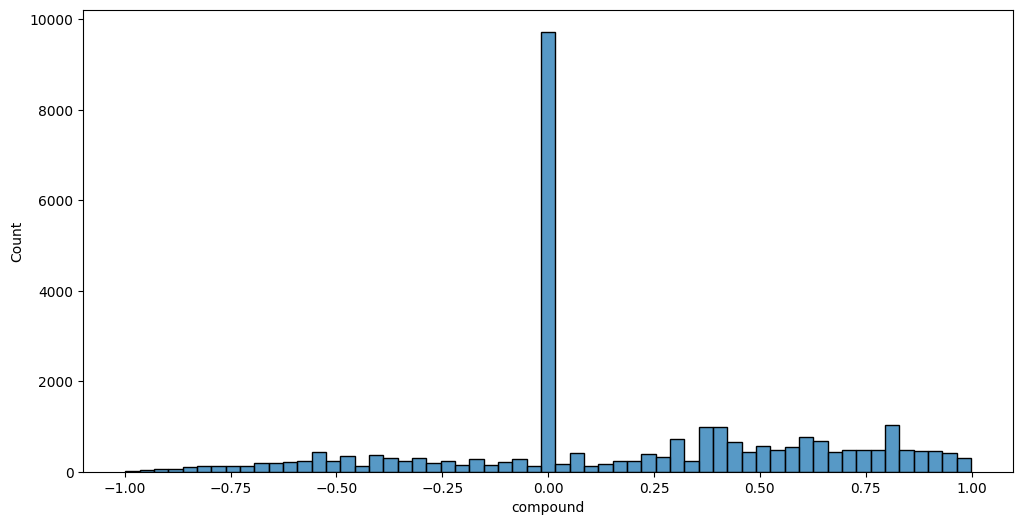

In [124]:
plt.figure(figsize=(12,6))
sns.histplot(data=df, x='compound')

In [125]:
scaler = MinMaxScaler()
normalized_df = pd.DataFrame(df[(df['score']>1)&(df['score']<1000)])
normalized_df['normalized_compound'] = scaler.fit_transform(normalized_df[['compound']])
normalized_df['normalized_score'] = scaler.fit_transform(normalized_df[['score']])

<Axes: xlabel='normalized_compound', ylabel='Count'>

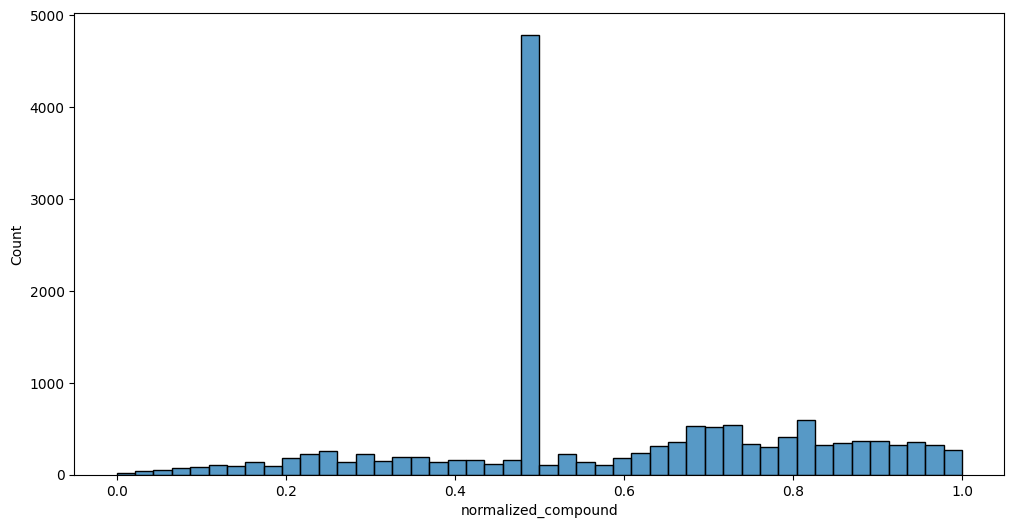

In [126]:
plt.figure(figsize=(12,6))
sns.histplot(data=normalized_df, x='normalized_compound')

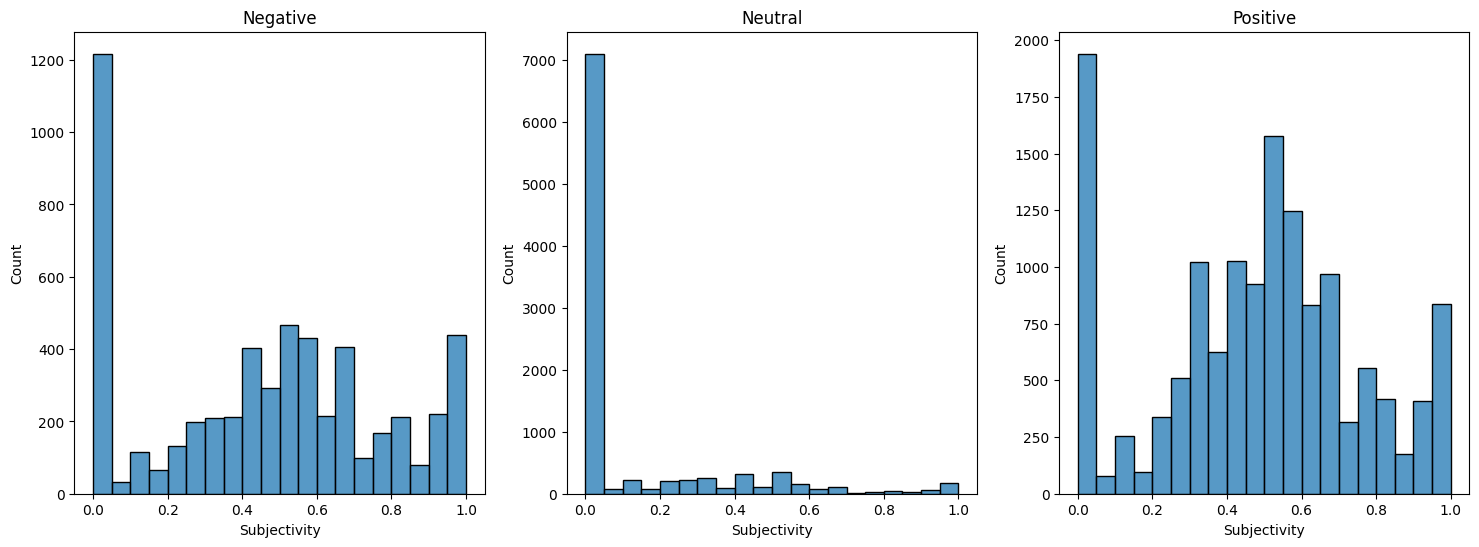

In [127]:
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
sns.histplot(data=df[df['category']=='negative'], x='Subjectivity',bins=20)
plt.title('Negative')
plt.subplot(1,3,2)
sns.histplot(data=df[df['category']=='neutral'], x='Subjectivity', bins=20)
plt.title('Neutral')
plt.subplot(1,3,3)
sns.histplot(data=df[df['category']=='positive'], x='Subjectivity', bins=20)
plt.title('Positive')
plt.show()

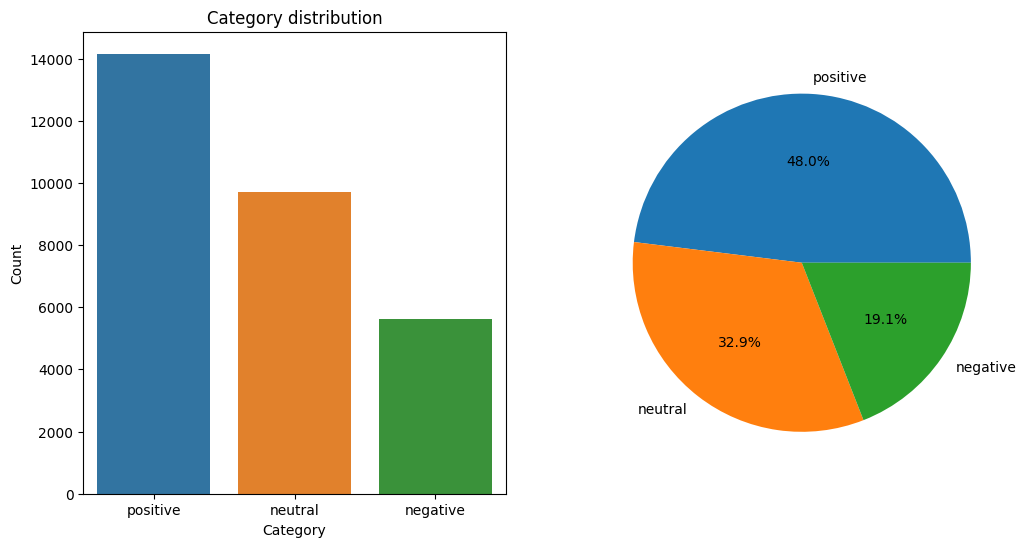

In [128]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
categories = df['category'].value_counts()
sns.barplot(x=categories.index, y=categories.values, hue=categories.index)
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Category distribution')
plt.subplot(1,2,2)
plt.pie(categories, labels=categories.index, autopct='%1.1f%%')
plt.show()

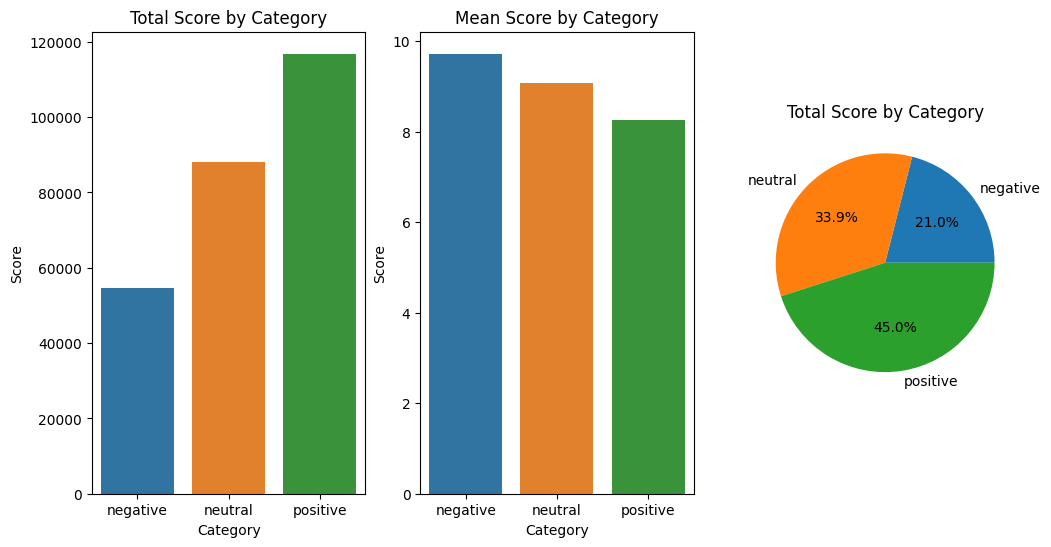

In [129]:
plt.figure(figsize=(12,6))
total_score = df.groupby('category')['score'].sum()
mean_score = df.groupby('category')['score'].mean()
plt.subplot(1,3,1)
sns.barplot(x=total_score.index, y=total_score.values, hue=total_score.index)
plt.xlabel('Category')
plt.ylabel('Score')
plt.title('Total Score by Category')

plt.subplot(1,3,2)
sns.barplot(x=mean_score.index, y=mean_score.values, hue=mean_score.index)
plt.xlabel('Category')
plt.ylabel('Score')
plt.title('Mean Score by Category')

plt.subplot(1,3,3)
plt.pie(total_score, labels=total_score.index, autopct='%1.1f%%')
plt.title('Total Score by Category')
plt.show()

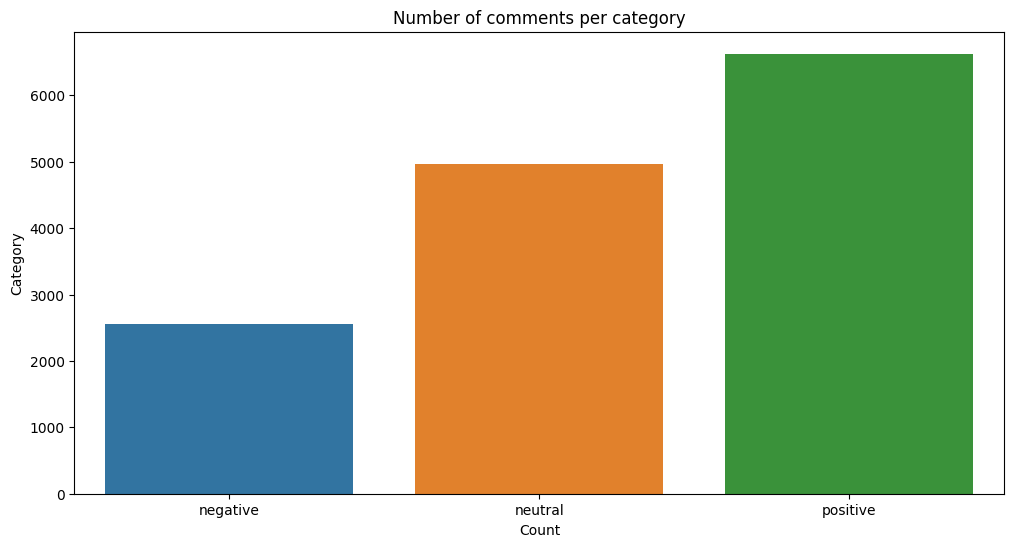

In [130]:
sc_data = df.loc[df['score']<=1].groupby('category')['category'].count()
plt.figure(figsize=(12,6))
sns.barplot(x=sc_data.index, y=sc_data.values, hue=sc_data.index)
plt.xlabel('Count')
plt.ylabel('Category')
plt.title('Number of comments per category')
plt.show()

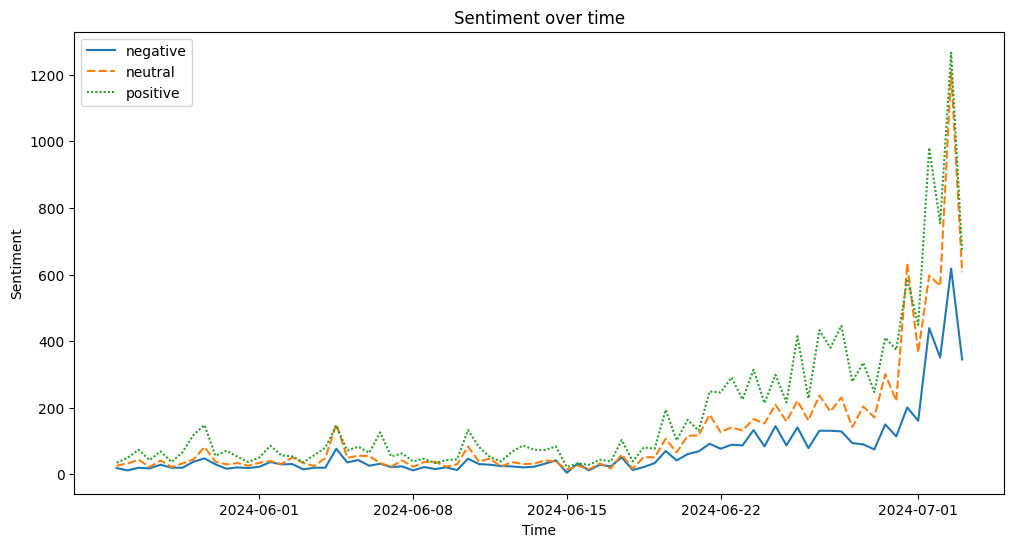

In [131]:
time_dist = df.groupby(pd.Grouper(key='created', freq='12h'))['category'].value_counts()
plt.figure(figsize=(12,6))
sns.lineplot(data=time_dist.unstack())
plt.title('Sentiment over time')
plt.xlabel('Time')
plt.ylabel('Sentiment')
plt.legend()
plt.show()

<Axes: xlabel='Subjectivity', ylabel='normalized_score'>

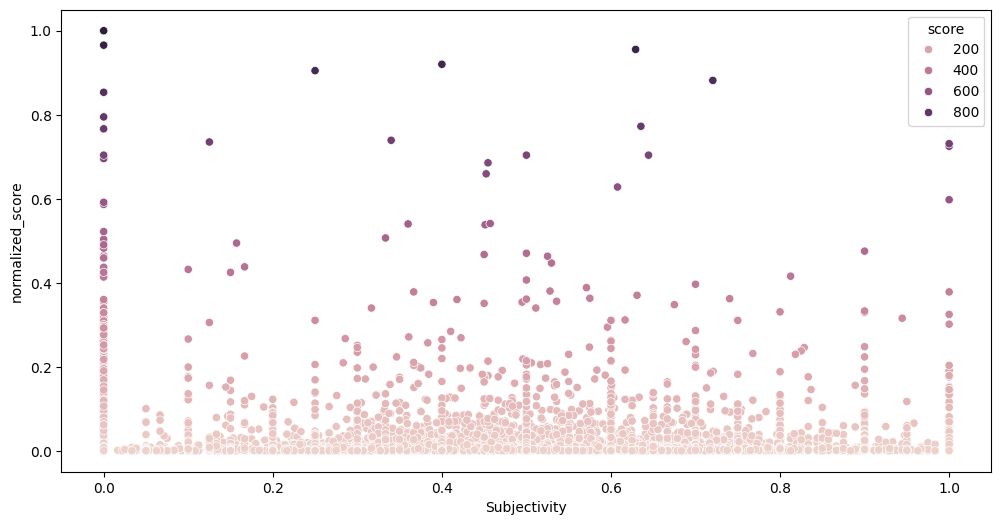

In [132]:
sc_data = df[(df['score']>2)&(df['score']<1000)]
plt.figure(figsize=(12,6))
sns.scatterplot(data=normalized_df, x='Subjectivity', y='normalized_score', hue='score')

<Axes: xlabel='normalized_compound', ylabel='score'>

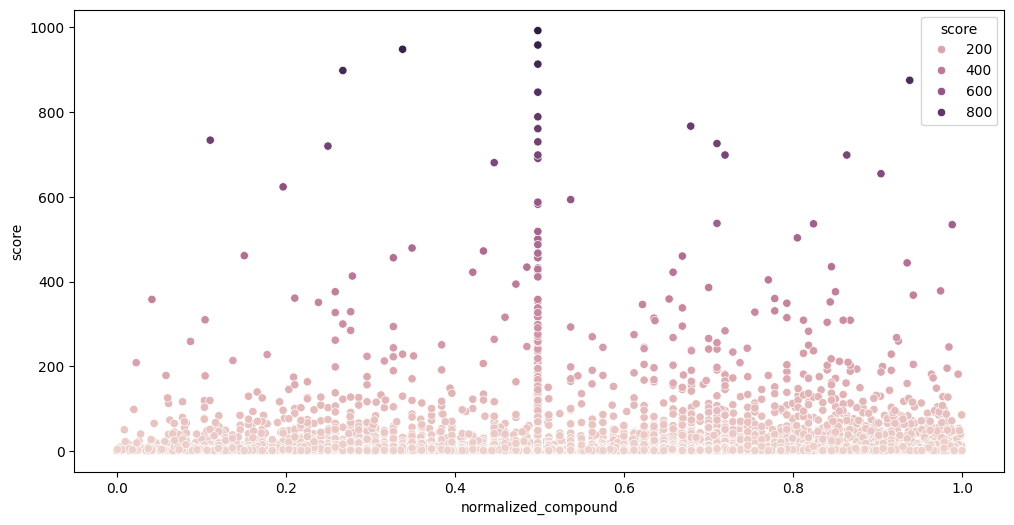

In [133]:
sc_data = df[(df['score']>2)&(df['score']<1000)]
plt.figure(figsize=(12,6))
sns.scatterplot(data=normalized_df, x='normalized_compound', y='score', hue='score')

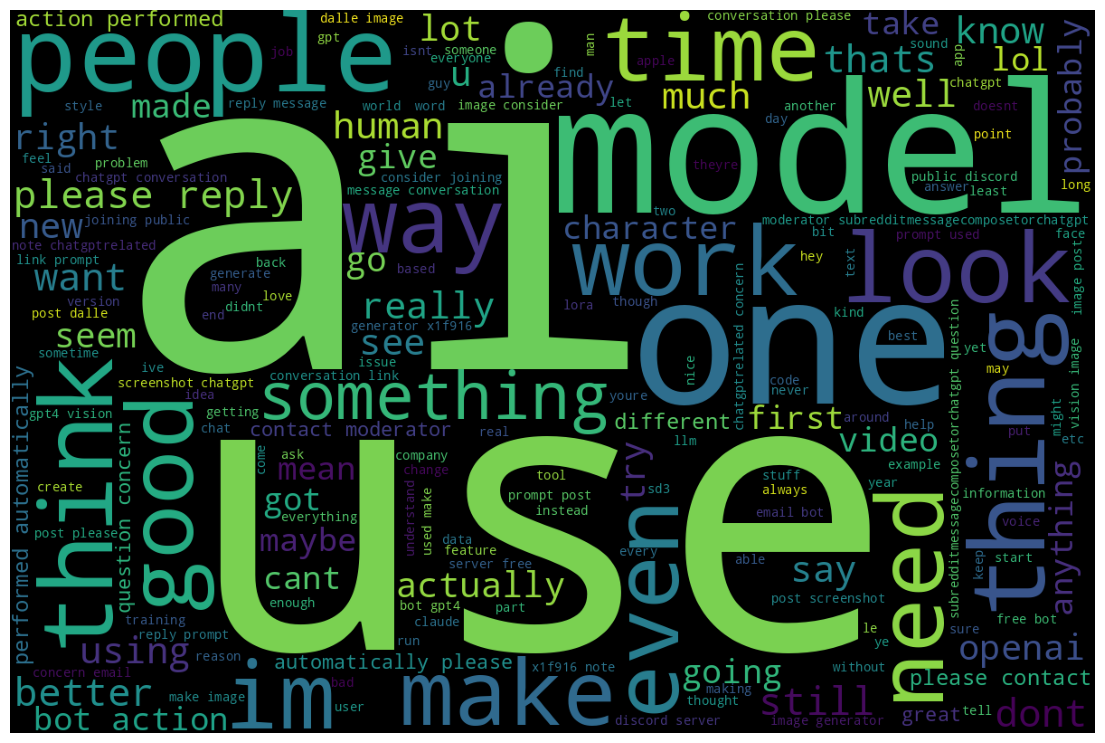

In [147]:
plt.figure(figsize=(14,10))
plt.imshow(WordCloud(stopwords=STOPWORDS, width=1200, height=800,).generate(df['processed_text'].str.cat(sep=' ')))
plt.axis('off')
plt.show()